In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
print(X_footsteps_accelerations_absolute.shape)
print(Y_footsteps_accelerations_absolute.shape)

(17248, 31)
(17248, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FR is swinging
idxs = np.where(X_footsteps_accelerations_absolute[:, -1] == 1)[0]
X_footsteps_accelerations_absolute_FR_swinging = X_footsteps_accelerations_absolute[idxs]
Y_footsteps_accelerations_absolute_FR_swinging = Y_footsteps_accelerations_absolute[idxs]

## Predict FR foot -> x

In [8]:
X_footsteps_accelerations_absolute_FR_swinging[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.1       ,  0.        ,
        0.        ,  0.09097511,  0.01569571,  0.03546102, -0.07442539,
        0.25578701,  0.13131595, -0.38037282,  0.22266933, -0.12780198,
       -0.381951  , -0.27515733,  0.12599015, -0.38960645, -0.2416217 ,
       -0.12631081, -0.38173601,  0.0753413 , -0.03407997, -0.01022839,
        0.09069058,  0.09356812, -0.00206157, -0.01183524,  0.        ,
        1.        ])

In [9]:
Y_footsteps_accelerations_absolute_FR_swinging[0, :]

array([ 0.03515556, -0.00011611,  0.03440189, -0.00369272])

### Linear Regression

In [10]:
def find_best_model(X, Y, runs=1000):
    best_model = None
    lowest_error = 100
    best_Xtr, best_Xte, best_Ytr, best_Yte = None, None, None, None
    
    for _ in range(runs):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.9, shuffle=True)
        
        model = LinearRegression()
        model.fit(X_train, Y_train)

        predictions = model.predict(X_test)
        error = np.max(np.abs(predictions - Y_test))

        if error < lowest_error:
            best_model = model
            lowest_error = error
            best_Xtr, best_Xte, best_Ytr, best_Yte = X_train, X_test, Y_train, Y_test

    # Stats
    predictions = best_model.predict(best_Xte)
    print('R2: ', r2_score(predictions, best_Yte))
    print('RMSE: ', np.sqrt(mean_squared_error(best_Yte, predictions)))
    print("The lowest error is: ", np.min(np.abs(predictions - best_Yte)))
    print("The highest error is: ", np.max(np.abs(predictions - best_Yte)))
    print("The avg. error is: ", np.mean(np.abs(predictions - best_Yte)))
    
    return best_Xte, best_Yte, predictions, best_model

In [37]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_FR_swinging[:, 0:1], # previous motion command
               X_footsteps_accelerations_absolute_FR_swinging[:, 3:4], # current motion command
               X_footsteps_accelerations_absolute_FR_swinging[:, -5:-4], # previous CoM velocity
               X_footsteps_accelerations_absolute_FR_swinging[:, 10:11], # FL (x,y) position
               X_footsteps_accelerations_absolute_FR_swinging[:, 13:14], # FR (x,y) position
               X_footsteps_accelerations_absolute_FR_swinging[:, 16:17], # RL (x,y) position
               X_footsteps_accelerations_absolute_FR_swinging[:, 19:20])) # RR (x,y) position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_FR_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_relative_swinging_x = find_best_model(X, Y, runs=5000)

R2:  0.9960443592648669
RMSE:  0.00609431203069396
The lowest error is:  3.23883246167167e-06
The highest error is:  0.019137708468898562
The avg. error is:  0.004762961144104882


In [38]:
model_fr_relative_swinging_x.coef_

array([[ 0.00957003,  0.01510242,  0.20082852, -0.44462315, -1.15561901,
         0.39886165,  0.33240783]])

In [39]:
model_fr_relative_swinging_x.intercept_

array([0.5708348])

In [40]:
inp = np.array([[0.9, 0.9, , 0.403, 0.094, -0.408, -0.09]])

In [41]:
out = model_fr_relative_swinging_x.coef_ @ inp.T
out += model_fr_relative_swinging_x.intercept_
print(out)

[[0.32947123]]


In [42]:
0.24888614 + out

array([[0.57835737]])

Text(0, 0.5, 'Predictions')

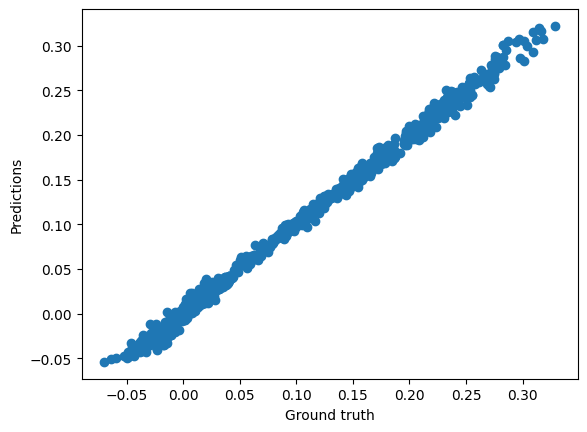

In [18]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [19]:
for idx, prediction in enumerate(predictions):
    print(f'{X_test[idx, 0]}->{X_test[idx, 1]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

0.8->0.8. Groundtruth: [0.23240674]. Predicted: [0.23190301]
0.7->0.6. Groundtruth: [0.13569981]. Predicted: [0.13779774]
0.0->0.0. Groundtruth: [0.00083312]. Predicted: [0.00116397]
0.3->0.3. Groundtruth: [0.07061574]. Predicted: [0.07615688]
0.3->0.3. Groundtruth: [0.08756779]. Predicted: [0.0954133]
0.1->0.1. Groundtruth: [0.03259335]. Predicted: [0.0315886]
0.0->0.0. Groundtruth: [0.0247498]. Predicted: [0.0240812]
0.8->0.9. Groundtruth: [0.26323501]. Predicted: [0.27301574]
0.7->0.7. Groundtruth: [0.2181426]. Predicted: [0.20349951]
0.0->0.0. Groundtruth: [-0.01774403]. Predicted: [-0.03471853]
0.0->0.0. Groundtruth: [0.01724429]. Predicted: [0.0139711]
0.7->0.5. Groundtruth: [0.16573125]. Predicted: [0.16127128]
0.0->0.0. Groundtruth: [-0.01217112]. Predicted: [-0.01343271]
0.8->0.8. Groundtruth: [0.25290916]. Predicted: [0.25748364]
0.0->0.0. Groundtruth: [0.01913616]. Predicted: [0.01180249]
0.2->0.8. Groundtruth: [0.14246964]. Predicted: [0.13692277]
0.9->0.9. Groundtruth: [0.

### Predict FL foot -> y

In [17]:
# Input
X = np.hstack((X_footsteps_accelerations_absolute_FR_swinging[:, 0:1], # previous motion command
               X_footsteps_accelerations_absolute_FR_swinging[:, 3:4], # current motion command
               X_footsteps_accelerations_absolute_FR_swinging[:, -5:-4], # previous CoM velocity
               X_footsteps_accelerations_absolute_FR_swinging[:, 10:12], # FL (x,y) position
               X_footsteps_accelerations_absolute_FR_swinging[:, 13:15], # FR (x,y) position
               X_footsteps_accelerations_absolute_FR_swinging[:, 16:18], # RL (x,y) position
               X_footsteps_accelerations_absolute_FR_swinging[:, 19:21])) # RR (x,y) position

# Labels
Y = np.array([Y_footsteps_accelerations_absolute_FR_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split dataset and fit best model
X_test, Y_test, predictions, model_fr_relative_swinging_y = find_best_model(X, Y, runs=5000)

R2:  0.9393648634455541
RMSE:  0.005838122497644202
The lowest error is:  1.3241619773673996e-05
The highest error is:  0.023297788777347034
The avg. error is:  0.004207787582547343


In [18]:
model_fr_relative_swinging_y.coef_

array([[-0.00427566,  0.00879939, -0.02124708, -0.49068711,  0.33456375,
        -0.32846635, -1.07320012,  0.33070733,  0.01404764,  0.53099461,
         0.24969151]])

In [19]:
model_fr_relative_swinging_y.intercept_

array([0.26797178])

Text(0, 0.5, 'Predictions')

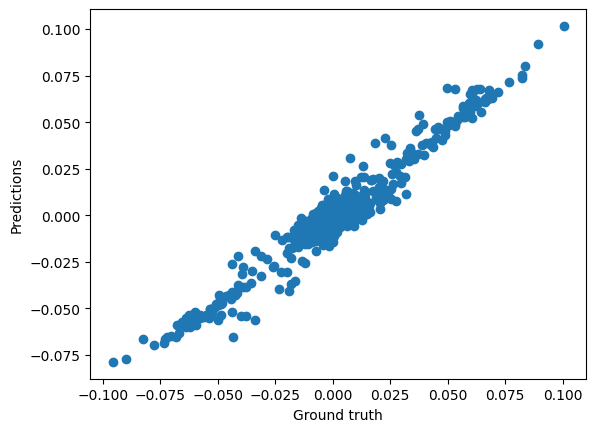

In [20]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [36]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')